# Cryptocurrency Trading Strategy

#### We will backtest , evaluate, and optimize a trading strategy that will be implemented in an algorthimic trading bot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def CryptoData(symbol, frequency):
    #Parameters: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

In [3]:
df = CryptoData(symbol = 'BTC_XRP', frequency = 300)
#When frequency = 300, data is refreshed every 5 minutes

We are interested developing a simple moving average (SMA) crossover strategy for trading Bitcoin and Ripple. A crossover is a relatively basic trading strategy that identifies shifts in price momentum that can be used as buy or sell signals. Our crossover strategy will consisit of a leading SMA and a lagging SMA. Leading SMA or the "short-term average" has less periods when calculating the average, so it is more sensitive to recent price changes. Lagging SMA or the "long-term average" has more periods, so it is less sensitive to recent price changes.

Text(0,0.5,'Price')

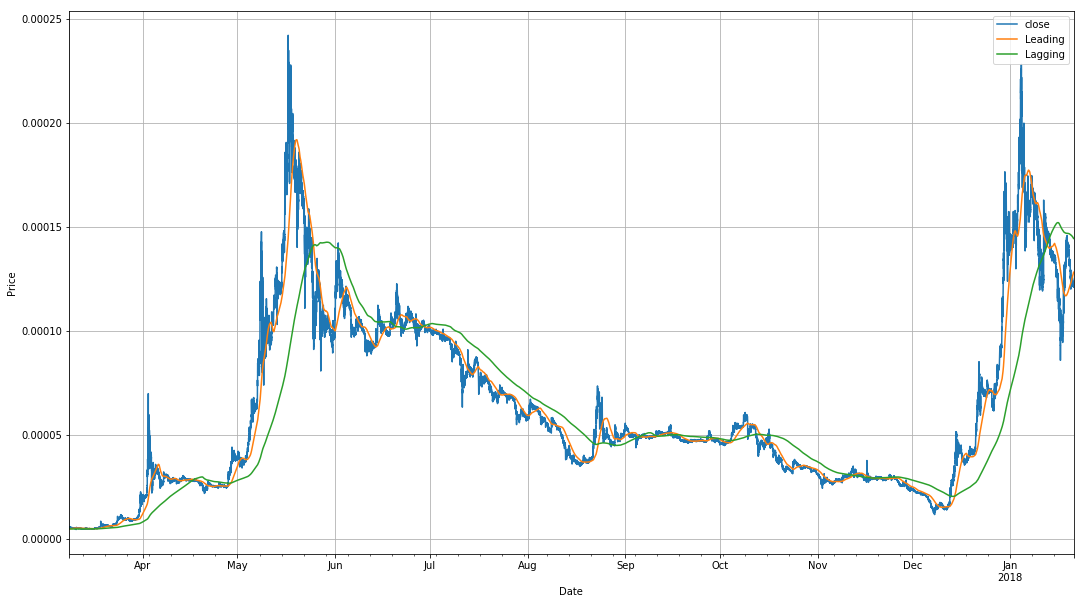

In [4]:
df['Leading'] = df['close'].rolling(1000).mean()
df['Lagging'] = df['close'].rolling(5000).mean()
df[['close','Leading','Lagging']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Trading Strategy: 
1. BUY if Leading SMA is ABOVE Lagging SMA by a certain threshold
2. SELL if Leading SMA is BELOW Lagging Simple Moving Avg. by a certain threshold

In [5]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

The 'regime' column dictates the buying and selling logic. When the value changes to 1, we buy, and then we don't sell until it changes to -1. A 0 would mean we have no position and wait until the next buy or sell signal. The 'Market' column is the log returns of the change in price between BTC and XRP. The 'Strategy' column is our returns when using the SMA crossover strategy. It is computed by multipling 'regime' (shifted forward to match the 'Market' column) by 'Market'

In [6]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage,Leading,Lagging,lead,lag,lead-lag,pc_diff,regime,Market,Strategy
date,,,,,,,,,,,,,,,,
2018-01-21 02:10:00,0.000122,0.000123,0.000122,0.000122,230751.843368,28.214032,0.000122,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133746,-1,14.400000,880.176780
2018-01-21 02:15:00,0.000122,0.000122,0.000121,0.000122,87395.712223,10.641359,0.000122,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.134362,-1,14.301176,886.258949
2018-01-21 02:20:00,0.000121,0.000122,0.000121,0.000122,345218.617788,41.824876,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.134532,-1,14.250588,889.405084
2018-01-21 02:25:00,0.000121,0.000122,0.000121,0.000121,84786.984906,10.280784,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133925,-1,14.284706,887.280825
2018-01-21 02:30:00,0.000121,0.000121,0.000121,0.000121,32266.225651,3.908796,0.000121,0.000128,0.000145,0.000128,0.000145,-0.000016,-0.133893,-1,14.256471,889.038107


In [7]:
ma_df[['Market','Strategy']].iloc[-1]

#Would have outperformed the market by a factor of about 46

Market       14.256471
Strategy    889.038107
Name: 2018-01-21 02:30:00, dtype: float64

Text(0,0.5,'BTC_XRP Return')

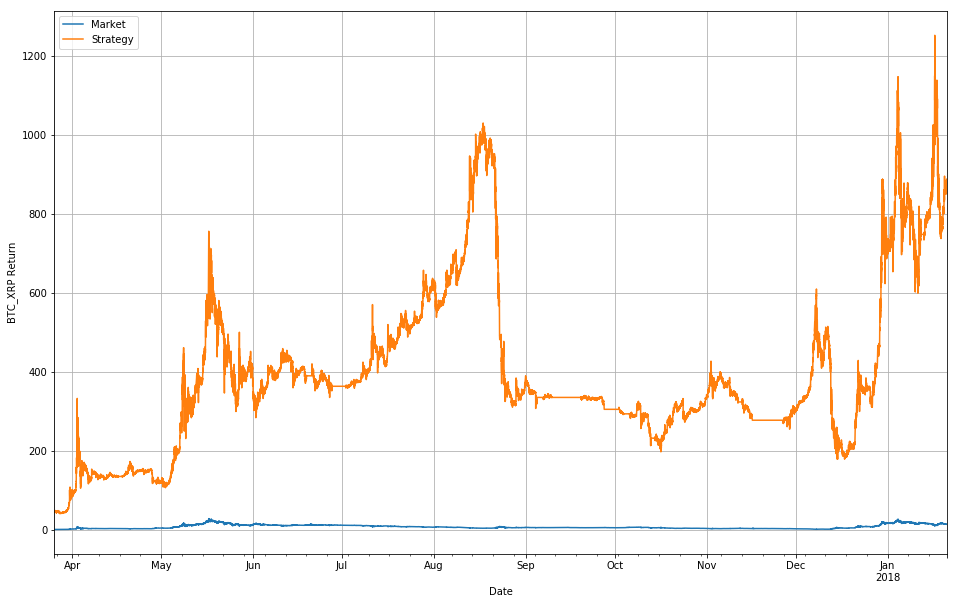

In [8]:
ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

We can improve on the lead and lag moving average strategy by finding the combination of values that yields the highest return or profit and loss (PnL). We can create an array of lead and lag pairs, loop over the array with the returns using our strategy create a heatmap to indentify the best pairs.

In [9]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [ ]:
for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    print(lead,lag,pnls[lead][lag])

ValueError: zero-size array to reduction operation minimum which has no identity

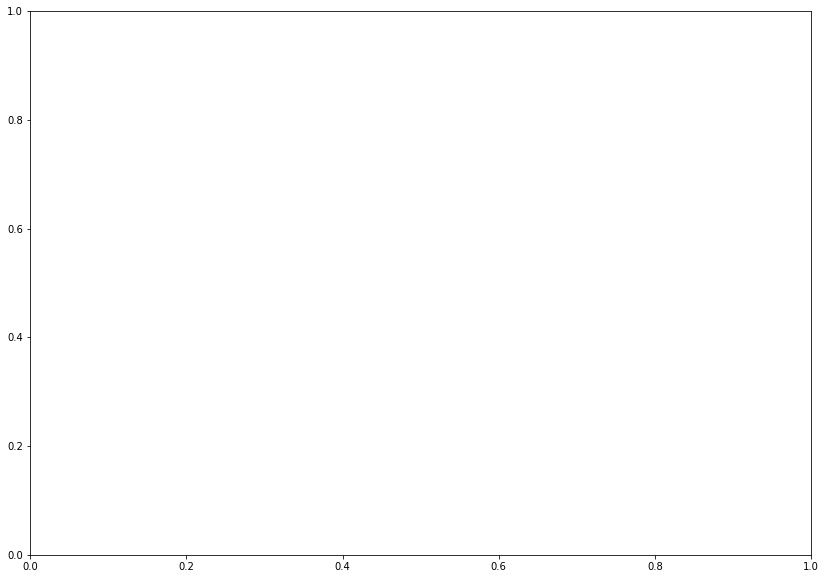

In [10]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs,cmap= 'PiYG')

In [20]:
PNLs.max()

100        7.373847
200       22.874261
300      469.083245
400     3275.100281
500     2242.432250
600     2062.100524
700     2576.226911
800     2306.636633
900     2279.989386
1000    2021.868796
1100    1555.571151
1200    1153.046843
1300     686.861522
1400     911.021181
1500     517.937410
1600     582.589843
1700     502.390579
1800     307.699530
1900     346.089703
2000     243.485201
2100     220.630666
2200     237.727208
2300     266.616924
2400     199.981377
2500     153.911417
2600     225.759400
2700     243.647137
2800     341.563448
2900    1302.084636
3000     471.558468
3100     591.146561
3200    1086.801818
3300    2938.564586
3400    2396.907988
3500    1720.364427
3600    1621.504291
3700    1066.570687
3800    1001.334034
3900     789.800533
4000     948.796314
dtype: float64

A lead of 400 periods and lag of 4300 periods produces the max PnL.

Text(0,0.5,'Price')

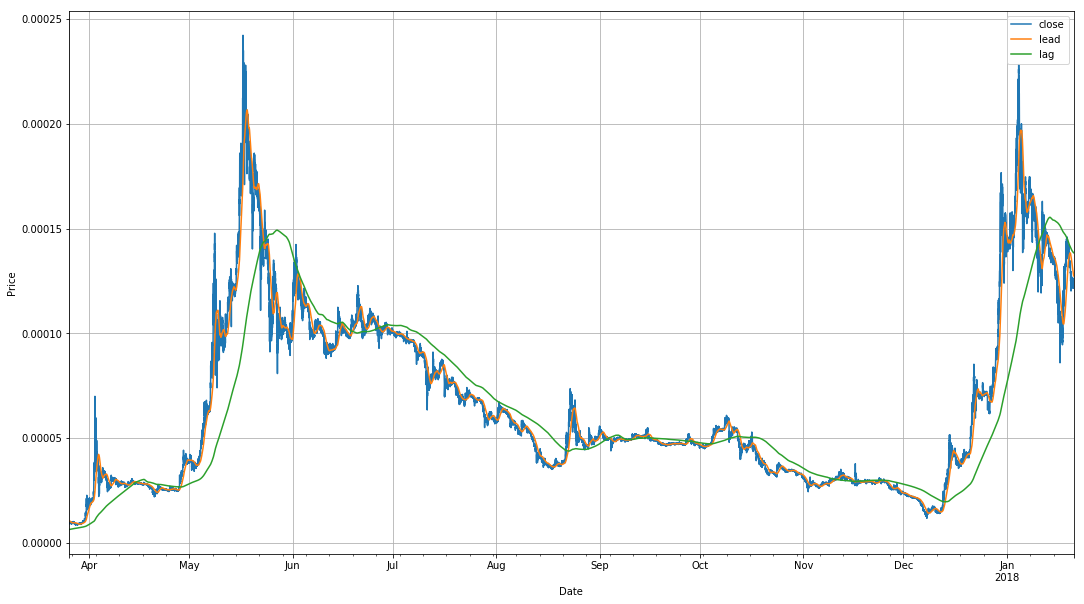

In [47]:
optimal_ma_df = test_ma(df, 400, 4300).dropna()
optimal_ma_df[['close','lead','lag']][270000:].plot(figsize = (18,10), grid = True)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0,0.5,'BTC_XRP Return')

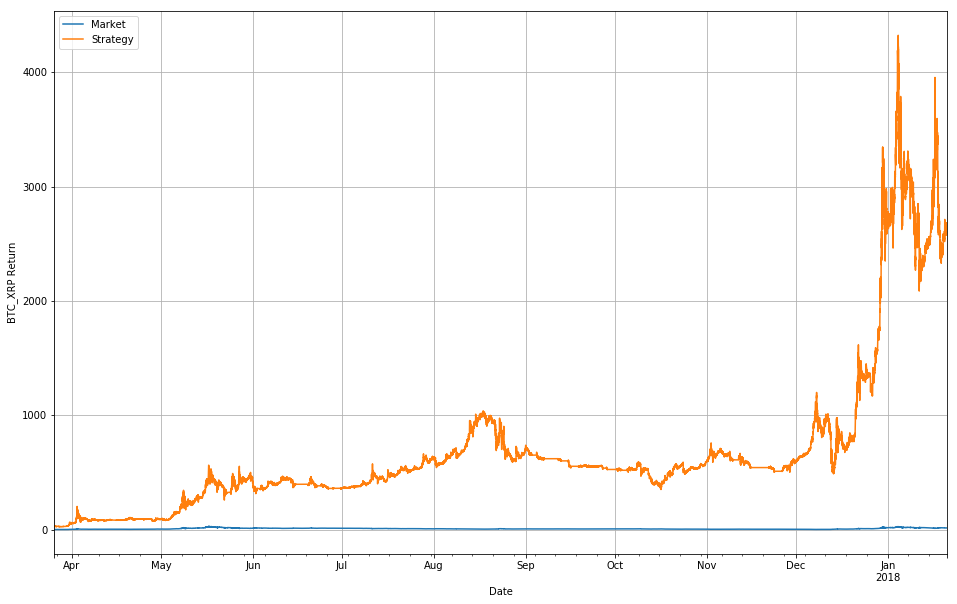

In [50]:
optimal_ma_df[['Market','Strategy']][270000:].plot(figsize = (16,10), grid = True)
plt.xlabel('Date')
plt.ylabel('BTC_XRP Return')

The next step would be to code an algorithmic trading bot that implements this strategy and interacts with an exchange's API.